In [1]:
pip install cross_validation

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cross_validation (from versions: none)
ERROR: No matching distribution found for cross_validation


In [3]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
import xgboost as xgb

In [4]:
# airbnb & test 파일을 데이터프레임으로 갖고 오기
airbnb_df=pd.read_csv('train_users.csv')
test_df=pd.read_csv('test_users.csv')

# 데이터 미리보기
airbnb_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [6]:
airbnb_df.info()
print('-----------------------------------------------')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [7]:
# 불필요한 열 삭제
airbnb_df=airbnb_df.drop(['date_account_created','timestamp_first_active'],axis=1)
test_df=test_df.drop(['date_account_created','timestamp_first_active'],axis=1)

<AxesSubplot:xlabel='country_destination', ylabel='count'>

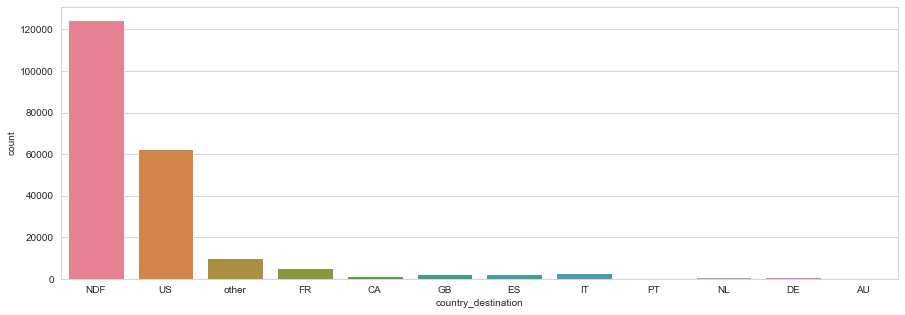

In [9]:
# 국가 : 목적지
airbnb_df['booked']=(airbnb_df['country_destination']!='NDF').astype(int)
# test_df['booked']=(test_df['country_destination'] != 'NDF').astype(int)

# 모든 국가_목적지 값에 대한 빈도 그림 그리기
fig, (axis1)=plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='country_destination',data=airbnb_df,palette='husl',ax=axis1)

NDF : 예약없음

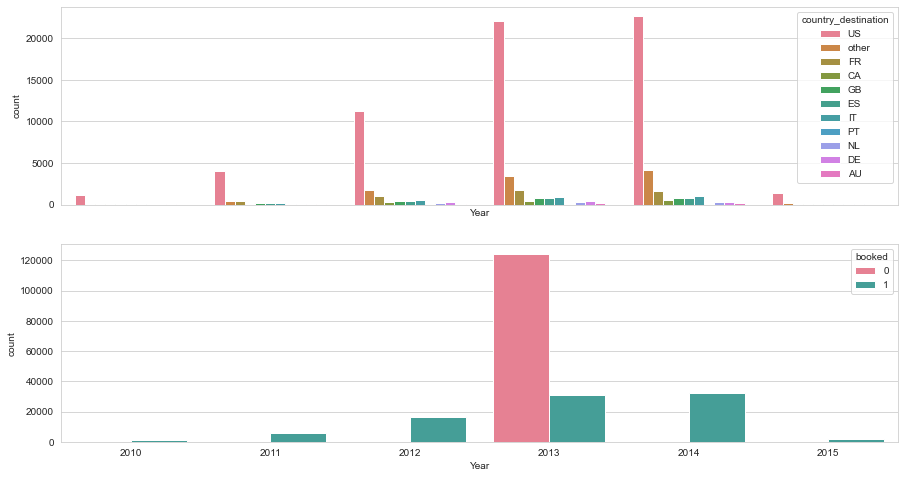

In [12]:
# 첫번째 부킹 날짜 (date_first_booking 칼럼)
def get_year(date):
    if date==date:
        return int(str(date)[:4])
    return date

def get_month(date):
    if date==date:
        return int(str(date)[5:7])
    return date

# 연도, 월 칼럼 만들기
airbnb_df['Year']=airbnb_df['date_first_booking'].apply(get_year)
airbnb_df['Month']=airbnb_df['date_first_booking'].apply(get_month)

test_df['Year']=test_df['date_first_booking'].apply(get_year)
test_df['Month']=test_df['date_first_booking'].apply(get_month)

# NaN 채우기
airbnb_df['Year'].fillna(airbnb_df['Year'].median(),inplace=True)
airbnb_df['Month'].fillna(airbnb_df['Month'].median(),inplace=True)

test_df['Year'].fillna(test_df['Year'].median(), inplace=True)
test_df['Month'].fillna(test_df['Month'].median(), inplace=True)

# int타입으로 바꾸기
airbnb_df[['Year','Month']]=airbnb_df[['Year','Month']].astype(int)
# test_df[['Year', 'Month']]   = test_df[['Year', 'Month']].astype(int)

# 그래프로 나타내기
fig, (axis1,axis2)=plt.subplots(2,1,sharex=True,figsize=(15,8))

# 연도별 country_destination 빈도
sns.countplot(x='Year',hue='country_destination',data=airbnb_df[airbnb_df['country_destination']!='NDF'],palette='husl',ax=axis1)

# 매년 예약한 사용자 수 vs 예약하지 않은 사용자 수
# 2014년과 2015년에는 "예약 없음"이 없었음.
sns.countplot(x='Year',hue='booked',data=airbnb_df,palette='husl',order=[2010,2011,2012,2013,2014,2015],ax=axis2)

# 칼럼 제거
airbnb_df.drop(['date_first_booking','Month'],axis=1,inplace=True)
test_df.drop(['date_first_booking','Month'],axis=1,inplace=True)

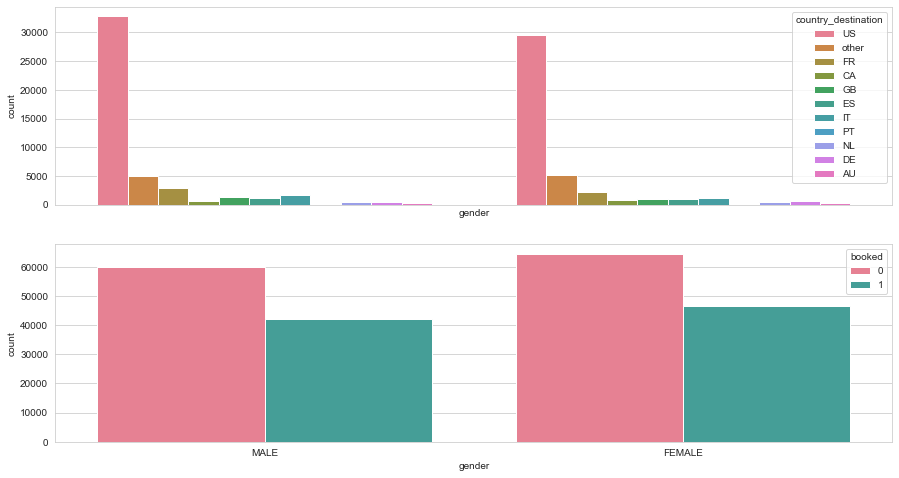

In [14]:
# gender

i=0
def get_gender(gender):
    global i
    # global : 전역변수로 설정 -> 바깥의 영역에서 사용가능하게 하는 기능
    if gender!='FEMALE' and gender!='MALE':
        return 'FEMALE' if (i % 2) else 'MALE'
    i=i+1
    return gender

# FEMALE, MALE을 제외한 모든 다른 변수들을 교체함
airbnb_df['gender']=airbnb_df['gender'].apply(get_gender)
test_df['gender']=test_df['gender'].apply(get_gender)

# Plot
fig, (axis1,axis2)=plt.subplots(2,1,sharex=True,figsize=(15,8))

# 모든 성별에 대한 country_destination의 빈도 (목적지가 없는 경우 제외)
sns.countplot(x='gender',hue='country_destination',data=airbnb_df[airbnb_df['country_destination']!='NDF'],palette='husl',ax=axis1)

# 성별에 따라 예약한 사용자 수(booked) V vs 예약하지 않은 사용자 수(no-booking)
sns.countplot(x='gender',hue='booked',data=airbnb_df,palette='husl',ax=axis2)

# gender data를 1과 0으로 바꿔주기
airbnb_df['gender']=airbnb_df['gender'].map({'FEMALE':1,'MALE':0})
test_df['gender']=test_df['gender'].map({'FEMALE':1,'MALE':0})

# 칼럼 제거
airbnb_df.drop(['gender'],axis=1,inplace=True)
test_df.drop(['gender'],axis=1,inplace=True)

In [17]:
# age

# 100이상인 모든 연령 값을 NaN에 할당하고, 이 NaN 값은 아래의 실제 연령으로 대체
airbnb_df['age'][airbnb_df['age']>100]=np.NaN
test_df['age'][test_df['age']>100]=np.NaN

# Airbnb_df에서 NaN 값의 평균, std 및 개수를 가져옴.
average_age_airbnb=airbnb_df['age'].mean()
std_age_airbnb=airbnb_df['age'].std()
count_nan_age_airbnb=airbnb_df['age'].isnull().sum()

# test_df에서 NaN 값의 평균, std 및 개수를 가져옴.
average_age_test   = test_df["age"].mean()
std_age_test       = test_df["age"].std()
count_nan_age_test = test_df["age"].isnull().sum()

# (평균 - 표준)과 (평균 + 표준) 사이에 난수 생성
rand_1 = np.random.randint(average_age_airbnb - std_age_airbnb, average_age_airbnb + std_age_airbnb, size = count_nan_age_airbnb)
rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

# 연령 열의 NaN 값을 생성된 임의의 값으로 채움.
airbnb_df["age"][np.isnan(airbnb_df["age"])] = rand_1
test_df["age"][np.isnan(test_df["age"])]     = rand_2

# 정수로 변환
airbnb_df['age']=airbnb_df['age'].astype(int)
test_df['age']=test_df['age'].astype(int)

<ipython-input-17-8271f38bee32>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb_df['age'][airbnb_df['age']>100]=np.NaN
<ipython-input-17-8271f38bee32>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['age'][test_df['age']>100]=np.NaN
<ipython-input-17-8271f38bee32>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb_df["age"][np.isnan(airbnb_df["age"])] = rand_1
<ipython-input-17-8271f38bee32>:23: SettingWithCopyWa

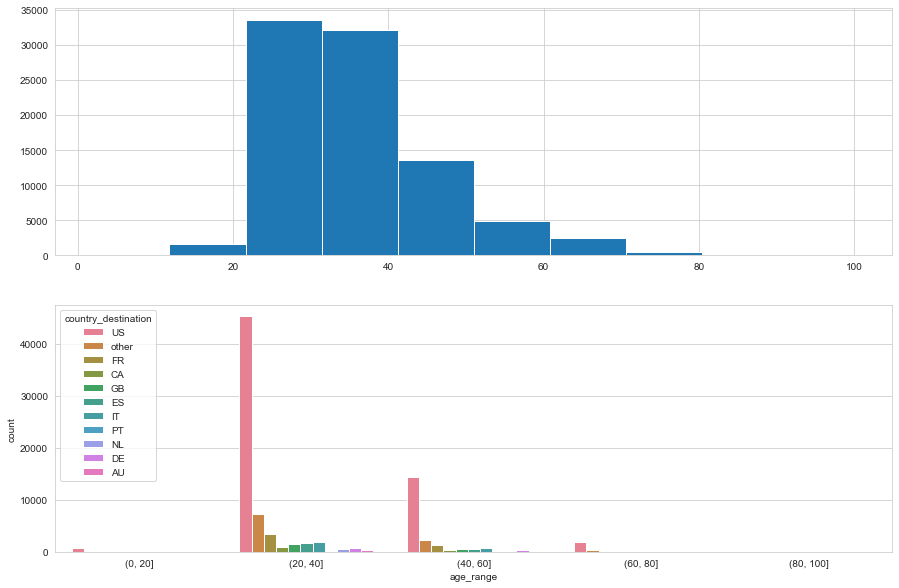

In [18]:
# age 이어서

# plot
fig, (axis1,axis2)=plt.subplots(2,1,figsize=(15,10))

# 연령 값에 대한 빈도(예약이 있는 경우)
airbnb_df['age'][airbnb_df['country_destination']!='NDF'].hist(ax=axis1)

# 나이 값을 범위로 나누기
airbnb_df['age_range']=pd.cut(airbnb_df['age'],[0,20,40,60,80,100])
# 각 연령대의 country_destination 빈도
sns.countplot(x='age_range',hue='country_destination',data=airbnb_df[airbnb_df['country_destination']!='NDF'],palette='husl',ax=axis2)

# age_range 제거
airbnb_df.drop(['age_range'],axis=1,inplace=True)

# 칼럼 제거
airbnb_df.drop(['age'],axis=1,inplace=True)
test_df.drop(['age'],axis=1,inplace=True)

In [32]:
# first_affiliate_tracked

# NaN값을 랜덤한 변수로 채우기
count_first_affiliate = 7    # len(np.unique(airbnb_df["first_affiliate_tracked"].value_counts()))

count_nan_department_airbnb = airbnb_df["first_affiliate_tracked"].isnull().sum()
count_nan_department_test   = test_df["first_affiliate_tracked"].isnull().sum()

rand_1 = np.random.randint(0, count_first_affiliate, size = count_nan_department_airbnb)
rand_2 = np.random.randint(0, count_first_affiliate, size = count_nan_department_test)

range_departments_airbnb = airbnb_df['first_affiliate_tracked'].value_counts().index
range_departments_test   = test_df['first_affiliate_tracked'].value_counts().index

airbnb_df["first_affiliate_tracked"][airbnb_df["first_affiliate_tracked"] != airbnb_df["first_affiliate_tracked"]] = range_departments_airbnb[rand_1]
test_df["first_affiliate_tracked"][test_df["first_affiliate_tracked"] != test_df["first_affiliate_tracked"]]       = range_departments_test[rand_2]

# drop columns
# airbnb_df.drop(['first_affiliate_tracked'], axis=1,inplace=True)
# test_df.drop(['first_affiliate_tracked'], axis=1,inplace=True)

<ipython-input-32-1cb1602f9410>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb_df["first_affiliate_tracked"][airbnb_df["first_affiliate_tracked"] != airbnb_df["first_affiliate_tracked"]] = range_departments_airbnb[rand_1]


AssertionError: 

In [33]:
# signup_method
airbnb_df["signup_method"] = (airbnb_df["signup_method"] == "basic").astype(int)
test_df["signup_method"]   = (test_df["signup_method"] == "basic").astype(int)

# signup_flow
airbnb_df["signup_flow"] = (airbnb_df["signup_flow"] == 3).astype(int)
test_df["signup_flow"]   = (test_df["signup_flow"] == 3).astype(int)

# language
airbnb_df["language"] = (airbnb_df["language"] == 'en').astype(int)
test_df["language"]   = (test_df["language"] == 'en').astype(int)

# affiliate_channel
airbnb_df["affiliate_channel"] = (airbnb_df["affiliate_channel"] == 'direct').astype(int)
test_df["affiliate_channel"]   = (test_df["affiliate_channel"] == 'direct').astype(int)

# affiliate_provider
airbnb_df["affiliate_provider"] = (airbnb_df["affiliate_provider"] == 'direct').astype(int)
test_df["affiliate_provider"]   = (test_df["affiliate_provider"] == 'direct').astype(int)

In [34]:
from sklearn import preprocessing

for f in airbnb_df.columns:
    if f == "country_destination" or f == "id": continue
    if airbnb_df[f].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(np.unique(list(airbnb_df[f].values) + list(test_df[f].values)))
        airbnb_df[f] = lbl.transform(list(airbnb_df[f].values))
        test_df[f]   = lbl.transform(list(test_df[f].values))

In [35]:
X_train = airbnb_df.drop(["country_destination", "id", 'booked'],axis=1)
Y_train = airbnb_df["country_destination"]
X_test  = test_df.drop("id",axis=1).copy()

In [36]:
# country_destination 값 수정
country_num_dic = {'NDF': 0, 'US': 1, 'other': 2, 'FR': 3, 'IT': 4, 'GB': 5, 'ES': 6, 'CA': 7, 'DE': 8, 'NL': 9, 'AU': 10, 'PT': 11}
num_country_dic = {y:x for x,y in country_num_dic.items()}

Y_train    = Y_train.map(country_num_dic)

In [39]:
# Xgboost 

params = {"objective": "multi:softmax", "num_class": 12}

T_train_xgb = xgb.DMatrix(X_train, Y_train)
X_test_xgb  = xgb.DMatrix(X_test)

gbm = xgb.train(params, T_train_xgb, 20)
Y_pred = gbm.predict(X_test_xgb)

[14:36:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [40]:
# convert type to integer
Y_pred = Y_pred.astype(int)

# change values back to original country symbols
Y_pred = Series(Y_pred).map(num_country_dic)

In [41]:
country_df = pd.DataFrame({
        "id": test_df["id"],
        "country": Y_pred
    })

submission = DataFrame(columns=["id", "country"])

# sort countries according to most probable destination country 
for key in country_df['country'].value_counts().index:
    submission = pd.concat([submission, country_df[country_df["country"] == key]], ignore_index=True)

submission.to_csv('airbnb.csv', index=False)